In [150]:
import pandas as pd
import json 
from collections import *
from glob import glob
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from numpy import reshape
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support

from sklearn.cluster import KMeans

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

from sklearn.dummy import DummyClassifier

In [151]:
df = pd.read_csv('/shared/2/projects/contextual-appropriateness/results/peft/best_model_preds.csv')
df.head()

,id,relationship,is_appropriate,label,quote,origin,text,answer,predicted
0,773,ex_dating,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0
1,773,colleague,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0
2,773,engaged,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0
3,773,best_friend,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0
4,773,neighbor,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0


In [172]:
Counter(df.origin)

Counter({'Adjudication': 478,
         'Perspective': 161,
         'Interpersonal': 94,
         'David': 213,
         'Agrima': 556,
         'first-round': 527})

In [152]:
rel_cats = pd.read_csv('/shared/2/projects/contextual-appropriateness/data/relationship_categories.csv')
rel_cats.replace({'Perr group': 'Peer group'}, inplace=True)
rel_cats.head()

,relationship,category
0,ex_dating,Romance
1,colleague,Organizational
2,engaged,Romance
3,best_friend,Social
4,neighbor,Social


In [153]:
datadir = '/shared/2/projects/contextual-appropriateness/data/final-annotated-data-cleaned/'
train_df = pd.read_csv(datadir + 'train.csv')

In [154]:
rel_counts = train_df[['relationship', 'id']].groupby('relationship').count().reset_index()
rel_counts['count'] = rel_counts['id']
del rel_counts['id']
rel_counts.head()

,relationship,count
0,acquaintance,193
1,adopted_child,170
2,best_friend,364
3,boss,330
4,child,172


In [155]:
rel_offensive = train_df[['relationship', 'label']].groupby('relationship').mean().reset_index()
rel_offensive['Percent Offensive'] = rel_offensive['label']
del rel_offensive['label']
rel_offensive.head()

,relationship,Percent Offensive
0,acquaintance,0.559585
1,adopted_child,0.435294
2,best_friend,0.057692
3,boss,0.718182
4,child,0.500000


In [156]:
df = df.merge(rel_cats, on='relationship', how='left')
df = df.merge(rel_counts, on='relationship', how='left')
df = df.merge(rel_offensive, on='relationship', how='left')
df.head()

,id,relationship,is_appropriate,label,quote,origin,text,answer,predicted,category,count,Percent Offensive
0,773,ex_dating,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0,Romance,222,0.265766
1,773,colleague,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0,Organizational,245,0.563265
2,773,engaged,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0,Romance,287,0.212544
3,773,best_friend,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0,Social,364,0.057692
4,773,neighbor,Yes,0,He needs to get high school diploma too,Adjudication,Rate whether it is inappropriate for this mess...,no,0,Social,217,0.479263


In [160]:
def score(sdf):
    cat = list(set(sdf.category))[0]
    count = list(set(sdf['count']))[0]
    po = list(set(sdf['Percent Offensive']))[0]
    
    p, r, f1, sup = precision_recall_fscore_support(sdf.label, sdf.predicted, average='binary')
    return pd.Series({'precision': p, 'recall': r, 'f1': f1, 
                      'Training Examples': count, 
                      'Category': cat,
                      'Percent Offensive': po})

res = df.groupby('relationship').apply(score).reset_index()
res.head()

,relationship,precision,recall,f1,Training Examples,Category,Percent Offensive
0,acquaintance,0.675676,0.833333,0.746269,193,Social,0.559585
1,adopted_child,0.714286,0.800000,0.754717,170,Family,0.435294
2,best_friend,0.142857,0.250000,0.181818,364,Social,0.057692
3,boss,0.823529,0.965517,0.888889,330,Organizational,0.718182
4,child,0.777778,0.777778,0.777778,172,Family,0.500000


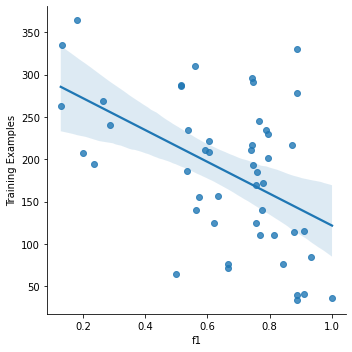

In [161]:
sns.lmplot(data=res, x='f1', y='Training Examples')

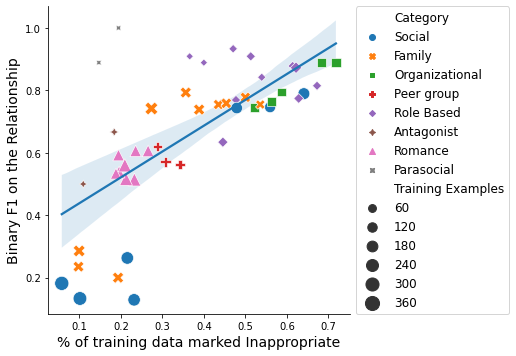

In [207]:
sns.lmplot(data=res, y='f1', x='Percent Offensive', scatter=False)
sns.scatterplot(data=res, y='f1', x='Percent Offensive', style='Category',
                hue='Category', size='Training Examples', sizes=(50, 200))
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0,
           prop={'size': 12})
plt.ylabel('Binary F1 on the Relationship', fontsize=14)
plt.xlabel('% of training data marked Inappropriate', fontsize=14)
plt.savefig('../../plots/error-analysis.pdf', bbox_inches = "tight")

In [163]:
res.head()

,relationship,precision,recall,f1,Training Examples,Category,Percent Offensive
0,acquaintance,0.675676,0.833333,0.746269,193,Social,0.559585
1,adopted_child,0.714286,0.800000,0.754717,170,Family,0.435294
2,best_friend,0.142857,0.250000,0.181818,364,Social,0.057692
3,boss,0.823529,0.965517,0.888889,330,Organizational,0.718182
4,child,0.777778,0.777778,0.777778,172,Family,0.500000


In [164]:
#res.columns
ncols = ['precision', 'recall', 'f1', 'Training Examples', 'Percent Offensive']
res[ncols].corr()

,precision,recall,f1,Training Examples,Percent Offensive
precision,1.000000,0.842052,0.975985,-0.460362,0.668641
recall,0.842052,1.000000,0.935406,-0.520981,0.625654
f1,0.975985,0.935406,1.000000,-0.491329,0.686055
Training Examples,-0.460362,-0.520981,-0.491329,1.000000,-0.070157
Percent Offensive,0.668641,0.625654,0.686055,-0.070157,1.000000


In [208]:
from scipy.stats import pearsonr

In [209]:
pearsonr(res.f1, res['Percent Offensive'])

PearsonRResult(statistic=0.6860548995460445, pvalue=5.31248198235561e-08)

In [210]:
pearsonr(res.f1, res['Training Examples'])

PearsonRResult(statistic=-0.49132934795273253, pvalue=0.000337254400253947)

In [211]:
print(res.sort_values(by='f1', ascending=False).to_latex(index=False, float_format="%.2f").replace('_', ' '))

\begin{tabular}{lrrrrlr}
\toprule
relationship & precision & recall & f1 & Training Examples & Category & Percent Offensive \\
\midrule
hero & 1.00 & 1.00 & 1.00 & 36 & Parasocial & 0.19 \\
doctor & 1.00 & 0.88 & 0.93 & 85 & Role Based & 0.47 \\
student & 0.83 & 1.00 & 0.91 & 115 & Role Based & 0.51 \\
client & 0.83 & 1.00 & 0.91 & 41 & Role Based & 0.37 \\
boss & 0.82 & 0.97 & 0.89 & 330 & Organizational & 0.72 \\
patient & 0.80 & 1.00 & 0.89 & 40 & Role Based & 0.40 \\
fan & 0.80 & 1.00 & 0.89 & 34 & Parasocial & 0.15 \\
direct report & 0.81 & 0.98 & 0.89 & 278 & Organizational & 0.68 \\
person with authority & 0.82 & 0.95 & 0.88 & 114 & Role Based & 0.61 \\
teacher & 0.83 & 0.92 & 0.87 & 217 & Role Based & 0.62 \\
lawyer & 0.89 & 0.80 & 0.84 & 76 & Role Based & 0.54 \\
landlord & 0.73 & 0.92 & 0.81 & 110 & Role Based & 0.67 \\
employee in large company & 0.70 & 0.92 & 0.80 & 230 & Organizational & 0.59 \\
uncle aunt & 0.72 & 0.88 & 0.79 & 202 & Family & 0.36 \\
complete stranger & 0

In [166]:
res.sort_values(by='f1').head(50)

,relationship,precision,recall,f1,Training Examples,Category,Percent Offensive
5,childhood_friend,0.153846,0.111111,0.129032,263,Social,0.231939
24,friend,0.125000,0.142857,0.133333,335,Social,0.101493
2,best_friend,0.142857,0.250000,0.181818,364,Social,0.057692
12,cousins,0.130435,0.428571,0.200000,207,Family,0.193237
45,step_sibling,0.153846,0.500000,0.235294,194,Family,0.097938
37,old_friend,0.294118,0.238095,0.263158,269,Social,0.215613
43,sibling,0.200000,0.500000,0.285714,241,Family,0.099585
42,rival,0.400000,0.666667,0.500000,64,Antagonist,0.109375
14,dating,0.473684,0.562500,0.514286,288,Romance,0.232639
21,engaged,0.400000,0.727273,0.516129,287,Romance,0.212544


In [167]:
res.head()

,relationship,precision,recall,f1,Training Examples,Category,Percent Offensive
0,acquaintance,0.675676,0.833333,0.746269,193,Social,0.559585
1,adopted_child,0.714286,0.800000,0.754717,170,Family,0.435294
2,best_friend,0.142857,0.250000,0.181818,364,Social,0.057692
3,boss,0.823529,0.965517,0.888889,330,Organizational,0.718182
4,child,0.777778,0.777778,0.777778,172,Family,0.500000
